In [21]:
from nilearn.regions import RegionExtractor
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from tqdm import tqdm
import nibabel as nib
import numpy as np
import pandas
import os
import glob
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from nilearn import plotting
from matplotlib import pyplot as plt
from nilearn import input_data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
import scipy as sp
import pickle
import seaborn
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

In [3]:
def create_trial_labels(subjectnum, sync_pulses, test_trials):
    # Filter by subject
    test_labels = test_trials[test_trials['Subject'] == subjectnum].copy()
    
    # Initialize Pandas data series for Start and End TRs, as well as for fmri_run number
    start_TR = pandas.Series(dtype = 'float32')
    end_TR = pandas.Series(dtype = 'float32')
    fmri_run = pandas.Series(dtype = 'float32')
    
    # Get order of task type for labeling wich fmri run each entry corresponds too
    time_indices = np.unique(test_labels['times'], return_index = True)[1]
    task_order = []
    [task_order.append(test_labels.iloc[[i]]['Task_type'].to_string().split()[1]) for i in time_indices]
    

    
    
    for i in sync_pulses.index:

        data = test_labels[test_labels['Task_type'] == sync_pulses.trial_type[i]].copy()

        trial_times = np.unique
        start_tr = np.floor((data["trial_starttime"].copy() - sync_pulses.getready_response[i]) / 720).astype(int)
        end_tr = np.floor((data["trial_endtime"].copy() - sync_pulses.getready_response[i]) / 720).astype(int)
        run_num = task_order.index(sync_pulses.trial_type[i])


        start_TR = pandas.concat([start_TR, pandas.Series(start_tr)])
        end_TR = pandas.concat([end_TR, pandas.Series(end_tr)])
        
        if run_num > 1:
            run_num = 'Run' + str(run_num - 1)
        elif run_num == 1:
            run_num = 'Ex2' 
        else:
            run_num = 'Ex'
        fmri_run = pandas.concat([fmri_run, pandas.Series([run_num] * len(end_tr))])
        
        
        
        
    test_labels = test_labels[['Subject', 'Task_type', 'trial_starttime', 'trial_endtime', 'accuracy']]
    
    test_labels['start_TR'] = start_TR.values
    test_labels['end_TR'] = end_TR.values
    test_labels['fmri_run'] = fmri_run.values

    
    return test_labels, task_order

In [4]:
def subject_timeseries(mlindiv_filename, confounds_filename, atlas_filename):
    
    # Load fmri volumes
    func_img = nib.load(mlindiv_filename)
    header_zooms = func_img.header.get_zooms()
    TR = header_zooms[3]

    pandas.read_csv(confounds_filename, sep = '\t').fillna(0).to_csv("conf_nona_temp.tsv", sep = '\t', index = False)

    print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)
    print('Func images are located in nifti image (4D) at: %s \n\t--- Confounds at: %s' % (mlindiv_filename, confounds_filename))
    print('Func images Voxel Dimensions (mm): %s\tFunc TR: %s' % (header_zooms[0:3], header_zooms[3]))

    # Create a masker from the HO atlas
    masker = input_data.NiftiMapsMasker(
        atlas_filename, 
        resampling_target='data',
        memory = 'nilearn_cache', 
        verbose = 0, low_pass=0.1, high_pass=0.01, detrend=True, t_r = TR).fit()


    # Create an overall time series for the run
    time_series = masker.transform(mlindiv_filename, confounds = 'conf_nona_temp.tsv')
    
    return time_series


In [5]:
def timewindows(timeseries, trial_labels, task_label, start_padding = 0, end_padding = 0):
    t_labels = trial_labels[trial_labels['Task_type'] == task_label]
    
    time_window_num = t_labels.shape[0]

    
    time_windows = []

    for i in range(time_window_num):
        
        start_TR = t_labels.start_TR.iloc[i] + start_padding
        end_TR = t_labels.end_TR.iloc[i] + end_padding
        
        time_window = timeseries[start_TR:end_TR, :]
        time_windows.append(time_window)
        
    return time_windows

In [6]:
def aggregate_timewindows(subject, func_directory, confounds_directory, trial_labels, atlas_filename, start_padding = 7, end_padding = 7):
    
    # Define list of files to be processed, given subject number and location of functional files.
    directory_path = "%s/sub-%s" % (func_directory, subject)
    trial_filenames = os.listdir(directory_path)
    print("Functional Images for Subject %s stored in %s" % (subject, directory_path))
    print("Functional files to be processed: " + str(trial_filenames))
    
    # Initialize empty Dictionary of Windowed - Time Series
    dict_timewindows = {}
    
    for run in trial_filenames:
        # Grab task label from matching the func run number to trial labels.
        run_name = run.split("bold")[1].split("_")[0]
        task_label = np.unique(trial_labels[trial_labels['fmri_run'] == run_name].Task_type)[0]
        print("Computing ROI Time Series for %s: %s" % (run_name, task_label))
        
        # Get path to func file and corresponding confounds file
        mlindiv_filename = directory_path+ '/' + run
        confounds_filename = glob.glob("%s/*%s*%s_*.tsv" % (confounds_directory, subject, run_name))[0]
        
        # Compute time series for func run
        time_series = subject_timeseries(mlindiv_filename, confounds_filename, atlas_filename)
        
        # Split time series into list time windows
        time_windows = timewindows(time_series, trial_labels, task_label, start_padding, end_padding)
        
        # For current Run, assign the list of time windows obtained from the previous line
        dict_timewindows[task_label] = time_windows
    
    return dict_timewindows

In [13]:
def threshold_array(array, threshold = 0):
    abs_thresh = np.quantile(np.abs(array), q = threshold)
    arr = ((array <= -abs_thresh) | (array >= abs_thresh)) * array
    return(arr)

def model_connectome(ts_list, ts_labels, subject_set, C = 1, n_splits = 10, 
                     fconn_types = ['correlation', 'partial correlation', 'tangent', 'covariance', 'precision'], 
                     plot_scores = True, zscore = False, thresh = 0, binarize = False):
    # If ts_list | ts_labels are a dictionary, collapse them into a list
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series

    # Define correlation types
    kinds = fconn_types
    _, classes = np.unique(ts_labels, return_inverse=True)
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.3)
    ts_array = np.asarray(ts_list)

    scores = {}

    for kind in kinds:
        print(kind.title())
        scores[kind] = []
        for train, test in tqdm(cv.split(ts_array, classes)):
            connectivity = ConnectivityMeasure(kind = kind, vectorize = True) # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
            connectomes = connectivity.fit_transform(ts_array[train])
            
            # Apply zscore transformation
            if zscore:
                connectomes = np.apply_along_axis(sp.stats.zscore, 1, connectomes)
                
            # Apply threshold
            if thresh:
                connectomes = np.apply_along_axis(threshold_array, 1, connectomes, threshold = thresh)
                
            # Apply binarize method
            if binarize:
                connectomes[np.nonzero(connectomes)] = 1

            classifier = LinearSVC(C = C).fit(connectomes, classes[train])
            
            ###
            # Initialze Test data
            ###
            
            connectomes_test = connectivity.transform(ts_array[test])
            
            # Apply zscore transformation
            if zscore:
                connectomes_test = np.apply_along_axis(sp.stats.zscore, 1, connectomes_test)
                
            # Apply threshold
            if thresh:
                connectomes_test = np.apply_along_axis(threshold_array, 1, connectomes_test, threshold = thresh)
                
            # Apply binarize method
            if binarize:
                connectomes_test[np.nonzero(connectomes_test)] = 1
            
            # Make predictions on test set, store model scores
            predictions = classifier.predict(connectomes_test)
            scores[kind].append(accuracy_score(classes[test], predictions)) 
    
    if plot_scores:
        chance_level = np.mean(ts_labels)
        print('CHANCE: ', chance_level)
        mean_scores = [np.mean(scores[kind]) for kind in kinds]
        print('MEAN MODEL ACC: ', mean_scores)
        scores_std = [np.std(scores[kind]) for kind in kinds]
    
        plt.figure(figsize=(6, 4))
        positions = np.arange(len(kinds)) * .1 + .1
        plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
        yticks = [k.replace(' ', '\n') for k in kinds]
        plt.yticks(positions, yticks)
        plt.gca().grid(True)
        plt.gca().set_axisbelow(True)
        plt.gca().axvline(chance_level, color='red', linestyle='--')
        plt.xlabel('Classification accuracy\n(red line = chance level)')
        plt.tight_layout()

    return(scores)

In [8]:
def subject_timeseries_labels(sub_num_list, behav_directory, func_directory, confounds_directory, sync_pulses_directory, atlas_filename, output_to_filename_base):
    '''
    This function takes a list of subject numbers and runs through several helper functions iterating over each subject
    to output a dictionary of subject - timeseries pairs (X) and a dictionary of subject - labels pairs (Y) to be run through any model.
        Requirements:
            - A behavioral directory containing the trial master.csv
            - a func directory pointing to the functional files to be used. Make sure there are no duplicate runs
            - a confoudns directory contianing only conformatted .tsv files (refer to R script conformat)
            - a directory containing syncpulse.csv files for each subject
    It takes roughly 45 secs to extract and properly label each ROI time series per Test Scan. So for scans looking at 6 runs it can take a little under 4 min to fully run. 
    It does store extractions in a cache, however, so when rerun using previously run subjects it should be a lot quicker.
    '''
    # Read in trial data
    test_trials = pandas.read_csv('%s/MLINDIV_trial_master.csv' % behav_directory)
    
    subject_timeseries = {}
    subject_labels = {}
    errored_subjects = {}
    
    # Loop through each subject's and create ROI timeseries for each trial
    for sub_num in sub_num_list:
        try:
            # Read in the sync_pulse start time data
            sync_pulses = pandas.read_csv('%s/sub-%s_syncpulses.csv' % (sync_pulses_directory, sub_num))

            # Create trial labels for the subject, using the sync pulse trial start time info
            trial_labels, _ = create_trial_labels(int(sub_num), sync_pulses, test_trials)

            # Extract ROI time series into a trial dictionary (keys = Run name, values = list of ROI time series for that run) for each trial timewindow defined by the trial labels
            sub_TW = aggregate_timewindows(sub_num, func_directory, confounds_directory, trial_labels, atlas_filename)

            ts_list = []
            ts_labels = []

            # Iterate through Subject's Trial dictionary, creating a List of timeseries (ts_list) and a list of accuracy labels for those timeseries irrespective of run type
            for tasktype in sub_TW.keys():
                if not tasktype.isnumeric():      
                    acc = list(trial_labels[trial_labels['Task_type'] == tasktype]['accuracy'])
                    [ts_labels.append(value) for value in acc]
                    for ts in sub_TW[tasktype]:
                        ts_list.append(ts)   

            subject_timeseries[sub_num] = ts_list
            subject_labels[sub_num] = ts_labels
        except Exception as e:
            errored_subjects[sub_num] = e
    
    xname = 'X_%s.pickle' % output_to_filename_base
    yname = 'Y_%s.pickle' % output_to_filename_base
    
    with open(xname, 'wb') as handle:
        pickle.dump(subject_timeseries, handle, protocol = pickle.HIGHEST_PROTOCOL)

    with open(yname, 'wb') as y_handle:
        pickle.dump(subject_labels, y_handle, protocol = pickle.HIGHEST_PROTOCOL)
            
    print(errored_subjects)
    return subject_timeseries, subject_labels

        

In [ ]:
atlas_filename = '/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLDL_162_thr25_regions.nii.gz'

base_dir = "/mnt/chrastil/lab/users/rob/projects/MachineLearning"

subs = ['014', '019', '020', '021', '024', '025', '027', '033', '043', '058',
        '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', 
        '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', 
        '079', '081', '082', '083', '084', '085', '086', '088', '089', '091', 
        '093', '094', '095', '096', '098', '099', '100','101', '102']

sub_X_dict, sub_Y_dict = subject_timeseries_labels(sub_num_list = subs, 
                                                   behav_directory = base_dir + '/behavioral',
                                                   func_directory = base_dir + '/func',
                                                   confounds_directory = base_dir + '/confounds',
                                                   sync_pulses_directory = base_dir + '/syncpulses',
                                                   atlas_filename = atlas_filename,
                                                   output_to_filename_base = 'MLDL_162_thr25_regions'
                                                  )


In [ ]:
with open('X_MLDL_162_thr25_regions.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_MLDL_162_thr25_regions.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)

error_dict = {}
good_subs = []
for subject in sub_X_dict.keys():
    try:
        model_connectome(sub_X_dict, sub_Y_dict, {subject}, C = 1, n_splits = 10, fconn_types = ['tangent'], plot_scores = False) 
    except Exception as e:
        error_dict[subject] = e
        # For error messages that begin with Th, we include them. These errors go away when model runs as a batch
        if 'Th' in str(e):
            good_subs.append(subject)
    else: 
        good_subs.append(subject)
        
print(good_subs)


scores = model_connectome(sub_X_dict, sub_Y_dict, set(good_subs), C = 0.005, n_splits = 30, fconn_types = ['correlation', 'partial correlation', 'tangent', 'covariance'])

['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']

# Baseline

In [9]:
with open('X_MLDL_162_thr25_regions.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_MLDL_162_thr25_regions.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)

CHANCE:  0.5845141700404858
MEAN MODEL ACC:  [0.7394041596402473, 0.7803822372119168]


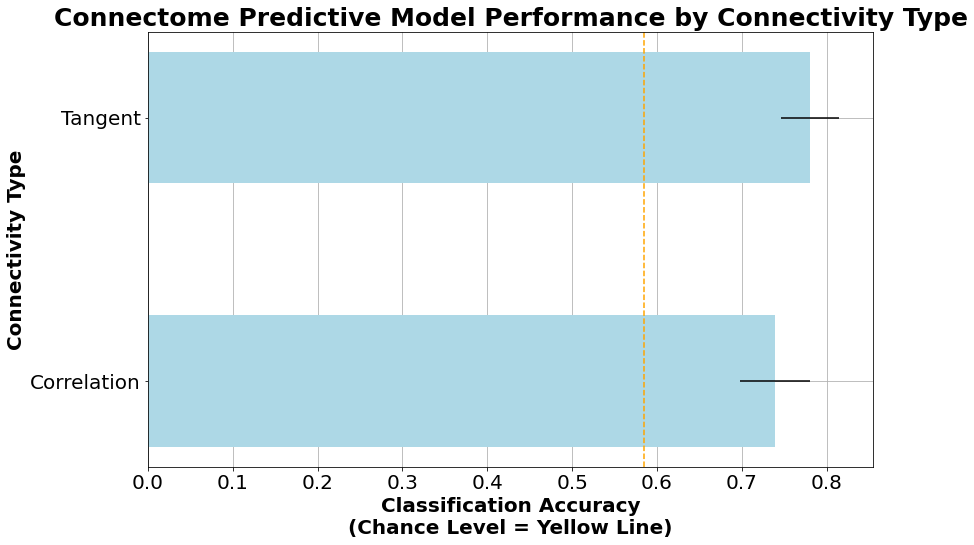

In [18]:
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']
#scores = model_connectome(sub_X_dict, sub_Y_dict, set(good_subs), C = 0.005, n_splits = 30, 
#                          fconn_types = ['correlation', 'tangent'],
#                         plot_scores = False)

good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029',
             '031', '032', '034', '036', '037', '045', '046', '049', '050', '060',
             '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', 
             '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', 
             '100', '101']

y = [sub_Y_dict[sub] for sub in good_subs]
y = [item for sublist in y for item in sublist]
kinds = ['correlation', 'tangent']

chance_level = np.mean(y)
print('CHANCE: ', chance_level)
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print('MEAN MODEL ACC: ', mean_scores)
scores_ci = [(1.96 * np.std(scores[kind])/np.mean(scores[kind])) for kind in kinds]


plt.figure(figsize=(13, 8), facecolor = 'white')
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_ci, color = 'lightblue')
yticks = [k.replace(' ', '\n').title() for k in kinds]
plt.yticks(positions, yticks, fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(chance_level, color='orange', linestyle='--')
plt.xlabel('Classification Accuracy\n(Chance Level = Yellow Line)', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.title('Connectome Predictive Model Performance by Connectivity Type', fontweight = 'bold', fontsize = 25)



plt.savefig('cpm_perf_bl.png')

# Baseline + Z-score

/opt/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
0it [00:00, ?it/s]

Correlation


10it [00:30,  3.02s/it]
0it [00:00, ?it/s]

Tangent


10it [53:28, 320.90s/it]

CHANCE:  0.5845141700404858
MEAN MODEL ACC:  [0.7360876897133221, 0.7472175379426644]


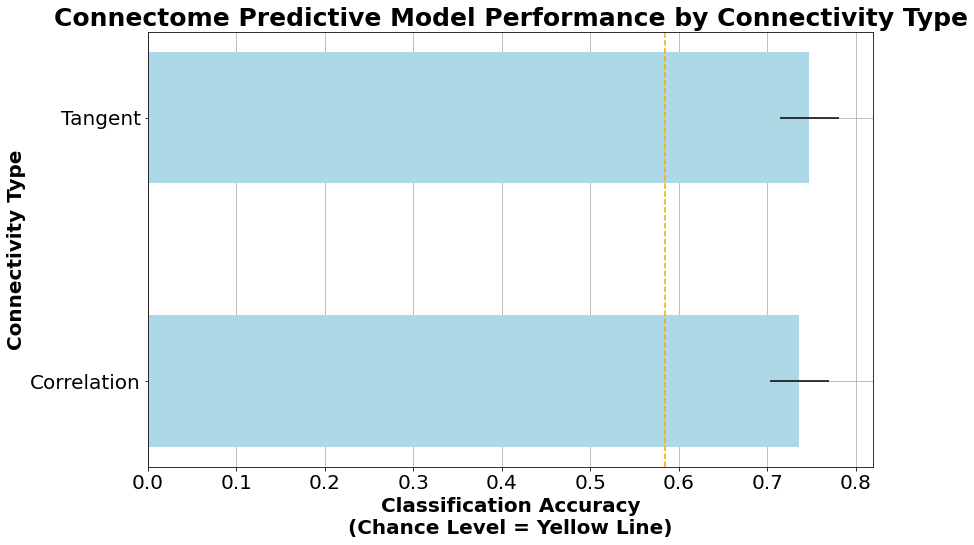

In [11]:
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']
scores = model_connectome(sub_X_dict, sub_Y_dict, set(good_subs), C = 1, n_splits = 10, 
                          fconn_types = ['correlation', 'tangent'],
                         plot_scores = False, zscore = True)

good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029',
             '031', '032', '034', '036', '037', '045', '046', '049', '050', '060',
             '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', 
             '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', 
             '100', '101']

y = [sub_Y_dict[sub] for sub in good_subs]
y = [item for sublist in y for item in sublist]
kinds = ['correlation', 'tangent']

chance_level = np.mean(y)
print('CHANCE: ', chance_level)
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print('MEAN MODEL ACC: ', mean_scores)
scores_ci = [(1.96 * np.std(scores[kind])/np.mean(scores[kind])) for kind in kinds]


plt.figure(figsize=(13, 8), facecolor = 'white')
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_ci, color = 'lightblue')
yticks = [k.replace(' ', '\n').title() for k in kinds]
plt.yticks(positions, yticks, fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(chance_level, color='orange', linestyle='--')
plt.xlabel('Classification Accuracy\n(Chance Level = Yellow Line)', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.title('Connectome Predictive Model Performance by Connectivity Type', fontweight = 'bold', fontsize = 25)


plt.savefig('cpm_perf_blz.png')

# Baseline + ZScore + Threshold

/opt/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
0it [00:00, ?it/s]

Correlation


10it [00:21,  2.15s/it]
0it [00:00, ?it/s]

Tangent


10it [51:59, 311.95s/it]

CHANCE:  0.5845141700404858
MEAN MODEL ACC:  [0.7293423271500842, 0.7414839797639123]


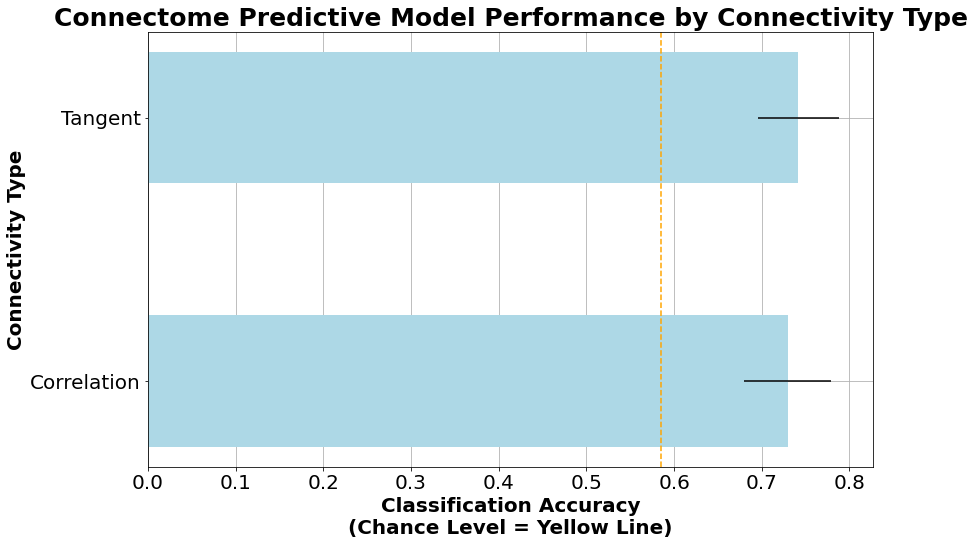

In [15]:
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']
scores = model_connectome(sub_X_dict, sub_Y_dict, set(good_subs), C = 1, n_splits = 10, 
                          fconn_types = ['correlation', 'tangent'],
                         plot_scores = False, zscore = True, thresh = 0.8)

good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029',
             '031', '032', '034', '036', '037', '045', '046', '049', '050', '060',
             '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', 
             '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', 
             '100', '101']

y = [sub_Y_dict[sub] for sub in good_subs]
y = [item for sublist in y for item in sublist]
kinds = ['correlation', 'tangent']

chance_level = np.mean(y)
print('CHANCE: ', chance_level)
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print('MEAN MODEL ACC: ', mean_scores)
scores_ci = [(1.96 * np.std(scores[kind])/np.mean(scores[kind])) for kind in kinds]


plt.figure(figsize=(13, 8), facecolor = 'white')
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_ci, color = 'lightblue')
yticks = [k.replace(' ', '\n').title() for k in kinds]
plt.yticks(positions, yticks, fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(chance_level, color='orange', linestyle='--')
plt.xlabel('Classification Accuracy\n(Chance Level = Yellow Line)', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.title('Connectome Predictive Model Performance by Connectivity Type', fontweight = 'bold', fontsize = 25)


plt.savefig('cpm_perf_blzt.png')

# Baseline + Zscore + Threshold + Binarize

/opt/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
0it [00:00, ?it/s]

Correlation


10it [00:22,  2.25s/it]
0it [00:00, ?it/s]

Tangent


10it [50:52, 305.25s/it]

CHANCE:  0.5845141700404858
MEAN MODEL ACC:  [0.6986509274873524, 0.6947723440134908]


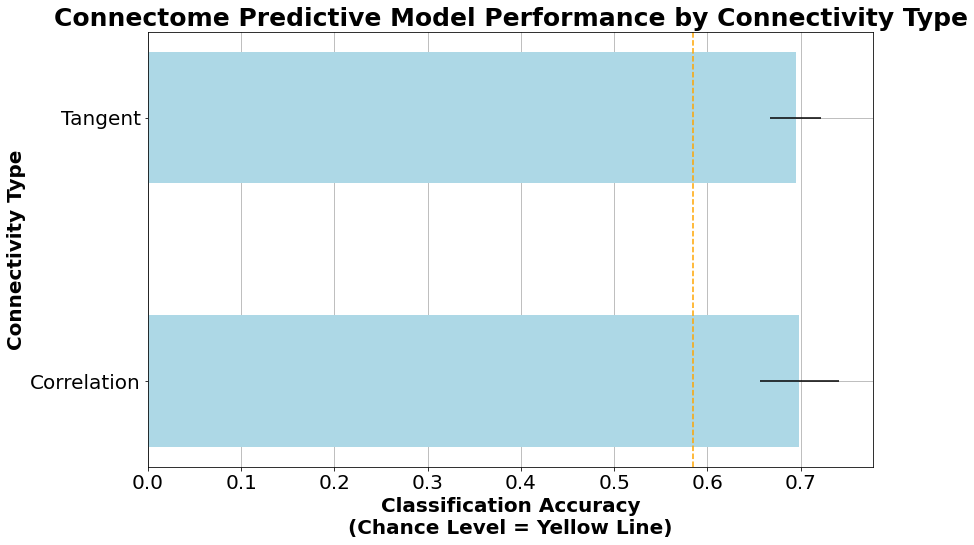

In [17]:
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']
scores = model_connectome(sub_X_dict, sub_Y_dict, set(good_subs), C = 0.05, n_splits = 10, 
                          fconn_types = ['correlation', 'tangent'],
                         plot_scores = False, zscore = True, thresh = 0.8, binarize = True)

good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029',
             '031', '032', '034', '036', '037', '045', '046', '049', '050', '060',
             '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', 
             '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', 
             '100', '101']

y = [sub_Y_dict[sub] for sub in good_subs]
y = [item for sublist in y for item in sublist]
kinds = ['correlation', 'tangent']

chance_level = np.mean(y)
print('CHANCE: ', chance_level)
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print('MEAN MODEL ACC: ', mean_scores)
scores_ci = [(1.96 * np.std(scores[kind])/np.mean(scores[kind])) for kind in kinds]


plt.figure(figsize=(13, 8), facecolor = 'white')
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_ci, color = 'lightblue')
yticks = [k.replace(' ', '\n').title() for k in kinds]
plt.yticks(positions, yticks, fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(chance_level, color='orange', linestyle='--')
plt.xlabel('Classification Accuracy\n(Chance Level = Yellow Line)', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.title('Connectome Predictive Model Performance by Connectivity Type', fontweight = 'bold', fontsize = 25)


plt.savefig('cpm_perf_blztb.png')

/opt/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
0it [00:00, ?it/s]

Correlation


10it [00:28,  2.89s/it]
0it [00:00, ?it/s]

Tangent


10it [50:56, 305.70s/it]

CHANCE:  0.5845141700404858
MEAN MODEL ACC:  [0.6620573355817875, 0.6760539629005059]


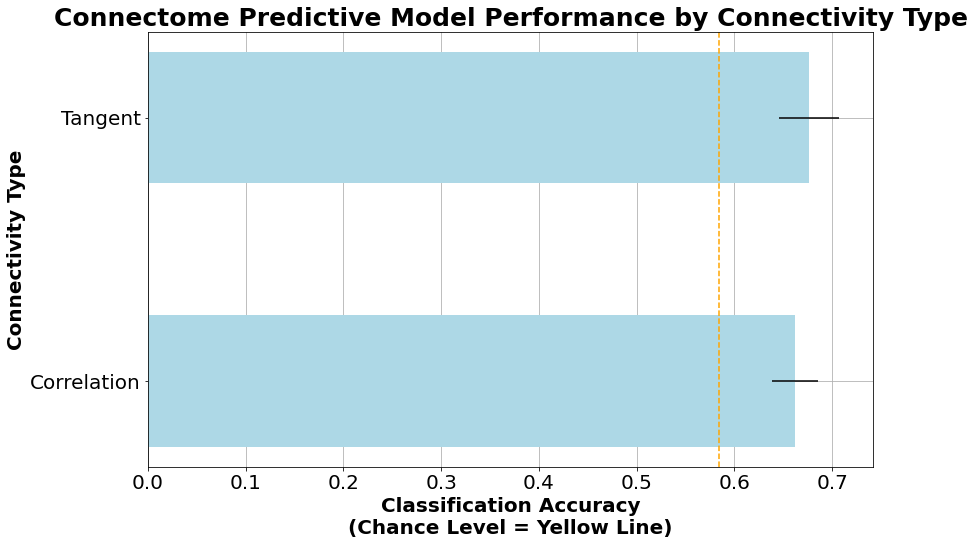

In [20]:
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']
scores = model_connectome(sub_X_dict, sub_Y_dict, set(good_subs), C = 1, n_splits = 10, 
                          fconn_types = ['correlation', 'tangent'],
                         plot_scores = False, zscore = True, thresh = 0.5, binarize = True)

good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029',
             '031', '032', '034', '036', '037', '045', '046', '049', '050', '060',
             '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', 
             '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', 
             '100', '101']

y = [sub_Y_dict[sub] for sub in good_subs]
y = [item for sublist in y for item in sublist]
kinds = ['correlation', 'tangent']

chance_level = np.mean(y)
print('CHANCE: ', chance_level)
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print('MEAN MODEL ACC: ', mean_scores)
scores_ci = [(1.96 * np.std(scores[kind])/np.mean(scores[kind])) for kind in kinds]


plt.figure(figsize=(13, 8), facecolor = 'white')
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_ci, color = 'lightblue')
yticks = [k.replace(' ', '\n').title() for k in kinds]
plt.yticks(positions, yticks, fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(chance_level, color='orange', linestyle='--')
plt.xlabel('Classification Accuracy\n(Chance Level = Yellow Line)', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.title('Connectome Predictive Model Performance by Connectivity Type', fontweight = 'bold', fontsize = 25)


plt.savefig('cpm_perf_blztb.png')

In [22]:
def return_Xy_data(ts_list, ts_labels, subject_set):
    subjects = []
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        subject_list = list(ts_labels.keys())
        
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
    
    
    for sub in sublist:
        subject_list = [sub] * len(sub_Y_dict[sub])
        for subject in subject_list:
            subjects.append(subject)
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series
    
    _, classes = np.unique(ts_labels, return_inverse=True)
    ts_array = np.asarray(ts_list)
    
    return ts_array, classes, subjects

In [23]:
with open('X_MLDL_162_thr25_regions.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_MLDL_162_thr25_regions.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)
    
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', 
             '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', 
             '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', 
             '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', 
             '100', '101']

X, y, subjects = return_Xy_data(sub_X_dict, sub_Y_dict, set(good_subs))

# connectivity = ConnectivityMeasure(kind = 'correlation') # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
# v_conn = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal=True)

NameError: name 'sublist' is not defined

In [ ]:
kinds = ['tangent', 'correlation', 'covariance', 'partial correlation']

scores, perm_scores, pvalues = {}, {}, {}

clf = LinearSVC(C = 0.005)
cv = StratifiedKFold(2, shuffle=True, random_state=0)
for kind in kinds:
    print(kind.title())
    connectivity = ConnectivityMeasure(kind = kind, vectorize = True, discard_diagonal=True)
    connectomes = connectivity.fit_transform(X)
    print("-----------------------------------------------------------------------------------------------")
    
    scores[kind], perm_scores[kind], pvalues[kind] = permutation_test_score(clf, connectomes, 
                                                                            y, 
                                                                            scoring="accuracy", 
                                                                            cv=cv, 
                                                                            n_permutations=1000, 
                                                                            verbose=1, 
                                                                            n_jobs=-1)
    print('%s-based Connectivity Predictive Model Performance \n\tModel Score:\t\t\t%.3f \n\tMean Permutation Score:\t\t%.3f \n\tp-value:\t\t\t%.3f' % (
        kind.title(), scores[kind], np.mean(perm_scores[kind]), pvalues[kind]))

In [12]:
for kind in kinds:
    print('%s-based Connectivity Predictive Model Performance \n\tModel Score:\t\t\t%.3f \n\tMean Permutation Score:\t\t%.3f \n\tp-value:\t\t\t%.3f' % (kind.title(), scores[kind], np.mean(perm_scores[kind]), pvalues[kind]))

Tangent-based Connectivity Predictive Model Performance 
	Model Score:			0.779 
	Mean Permutation Score:		0.537 
	p-value:			0.001
Correlation-based Connectivity Predictive Model Performance 
	Model Score:			0.729 
	Mean Permutation Score:		0.520 
	p-value:			0.001
Covariance-based Connectivity Predictive Model Performance 
	Model Score:			0.698 
	Mean Permutation Score:		0.514 
	p-value:			0.001
Partial Correlation-based Connectivity Predictive Model Performance 
	Model Score:			0.624 
	Mean Permutation Score:		0.585 
	p-value:			0.001


In [17]:
def best_model(ts_array, classes, kind, C, n_splits):
    scores = []
    high_score = 0
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.3)
    count = 0
    
    
    for train, test in cv.split(ts_array, classes):
            count += 1
            pct_complete = (count/n_splits) * 100
            print("%0.3f Percent Complete" % pct_complete,  end = "\r", flush = True)
            
            connectivity = ConnectivityMeasure(kind = kind, vectorize = True, discard_diagonal = True) # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
            connectomes = connectivity.fit_transform(ts_array[train])

            classifier = LinearSVC(C = C).fit(connectomes, classes[train])
            predictions = classifier.predict(connectivity.transform(ts_array[test]))
            acc_score = accuracy_score(classes[test], predictions)
            scores.append(acc_score) 
            
            if acc_score > high_score:
                best_model = classifier
                high_score = acc_score
                

    
    return scores, best_model
            

scores, best_model = best_model(X, y, 'tangent', 0.005, 10)

In [18]:
# save the model to disk
filename = 'MLDL-162-bestmodel.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [19]:
print(scores)

[0.8010118043844857, 0.790893760539629, 0.7639123102866779, 0.7824620573355818, 0.7959527824620574, 0.7858347386172007, 0.7790893760539629, 0.7875210792580101, 0.7858347386172007, 0.7892074198988196]


In [20]:
connectivity = ConnectivityMeasure(kind = 'tangent', vectorize = True, discard_diagonal = True)
connectivity.fit_transform(X)

def create_binned_performance(X, y, model, connectivity):
    window_size, true_accuracy, pred_accuracy, correct_prediction = [], [], [], []
    
    for index, connectome in enumerate(X):
        window_size.append(connectome.shape[0])
        true_accuracy.append(y[index])
        pred_accuracy.append(best_model.predict(connectivity.transform([X[index]]))[0])
        correct_prediction.append(y[index] == best_model.predict(connectivity.transform([X[index]]))[0])
        
    
    d = {'window_size': window_size, 'true_acc': true_accuracy, 'pred_acc': pred_accuracy, 'correct_prediction': correct_prediction}
    best_model_df = pandas.DataFrame(d)
    return best_model_df
    

best_model_df = create_binned_performance(X, y, best_model, connectivity)

In [137]:
best_model_df.columns

Index(['subject', 'window_size', 'true_acc', 'pred_acc', 'model_correct'], dtype='object')

R: 0.037	p-value: 0.101


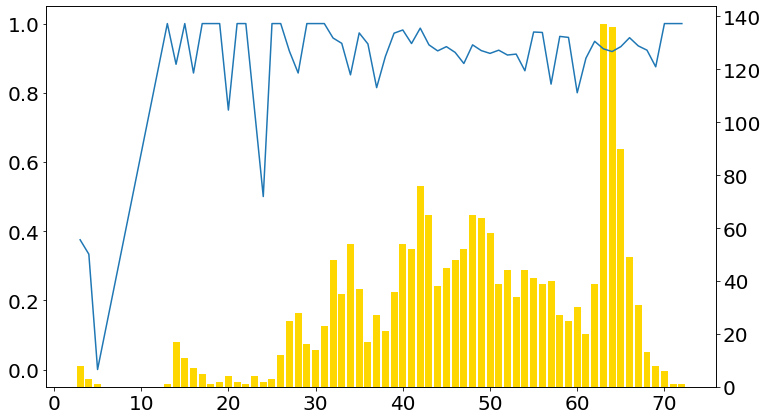

In [158]:
q_num = 20

size_by_correct = best_model_df[['window_size', 'model_correct']].groupby('window_size').mean()
size_by_correct['number'] = best_model_df[['window_size', 'model_correct']].groupby('window_size').count()
size_by_correct['acc'] = best_model_df[['window_size', 'true_acc']].groupby('window_size').mean()

sbc = size_by_correct[size_by_correct.number >= 0]

fig = plt.figure(figsize=(12, 7), facecolor = 'white')
ax1 = fig.add_subplot(111)
ax1.plot(list(sbc.index), sbc.model_correct, zorder = 1)


ax2 = ax1.twinx()
ax2.bar(list(sbc.index), sbc.number, color = 'gold')

labels = pandas.qcut(list(sbc.index), q=q_num).unique()
ax1.set_zorder(10)
ax1.patch.set_visible(False)

ax1.tick_params(axis='both', labelsize = 20)
plt.yticks(fontsize = 20)



r, p = scipy.stats.pearsonr(best_model_df.window_size, best_model_df.model_correct)
print("R: %.3f\tp-value: %.3f" % (r, p))

plt.savefig('tan_perf_trialduration.png')

Tangent Linear SVC Mean Accuracy: 77.996% +/-(0.008)
Correlation Linear SVC Mean Accuracy: 73.158% +/-(0.007)


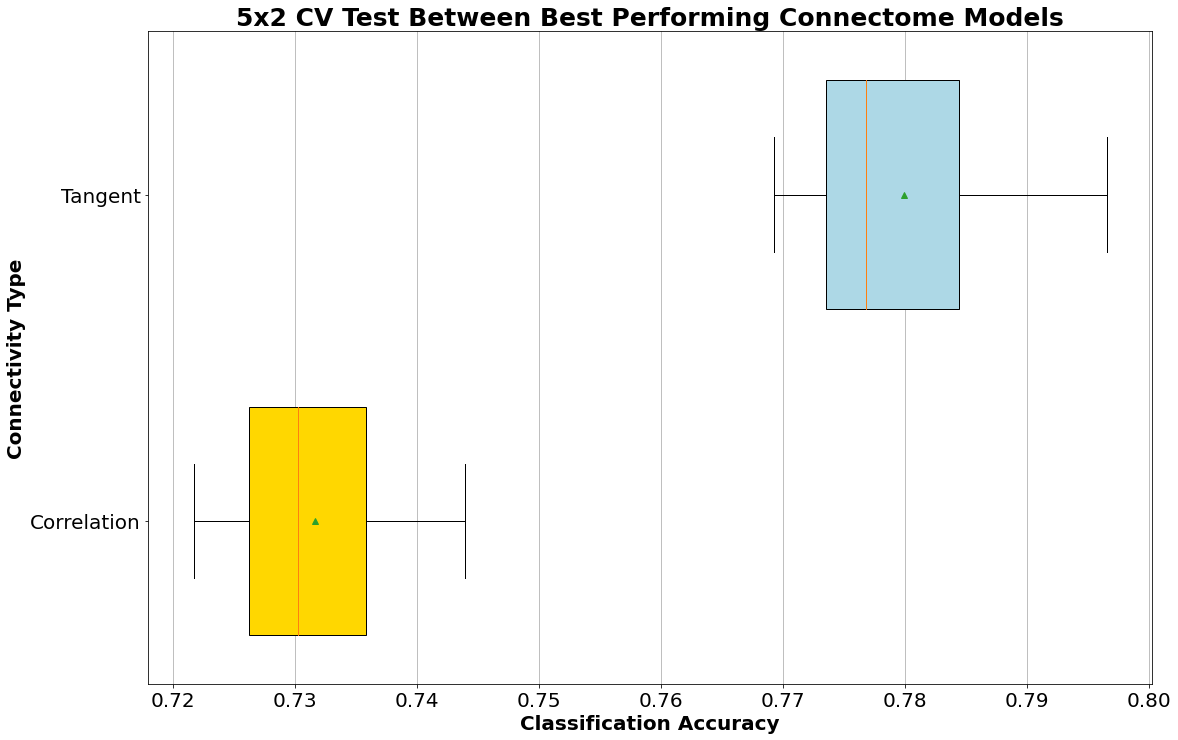

In [24]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


# evaluate model 1
model1 = LinearSVC(C=0.005)

tan_connectivity = ConnectivityMeasure(kind = 'tangent', vectorize = True, discard_diagonal=True)
tangent_connectomes = tan_connectivity.fit_transform(X)

cv1 = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 5, random_state = 1)
scores1 = cross_val_score(model1, tangent_connectomes, y, scoring = 'accuracy', cv = cv1, n_jobs = -1)
print('Tangent Linear SVC Mean Accuracy: %.3f%% +/-(%.3f)' % (np.mean(scores1*100), np.std(scores1)))

# evaluate model 2
model2 = LinearSVC(C=0.005)

corr_connectivity = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal=True)
corr_connectomes = corr_connectivity.fit_transform(X)

cv2 = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 5, random_state = 1)
scores2 = cross_val_score(model2, corr_connectomes, y, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print('Correlation Linear SVC Mean Accuracy: %.3f%% +/-(%.3f)' % (np.mean(scores2*100), np.std(scores2)))

# plot the results
dict_scores = {'Tangent': scores1, 
              'Correlation': scores2}

plt.figure(figsize=(18, 12), facecolor = 'white')
bplot = plt.boxplot([scores2, scores1], labels=['Correlation', 'Tangent'], showmeans=True, patch_artist=True, vert=False, widths = 0.7)
colors = ['gold', 'lightblue']

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


plt.gca().xaxis.grid(True)
plt.xticks(fontsize = 20)

plt.yticks(fontsize = 20)
plt.title('5x2 CV Test Between Best Performing Connectome Models', fontweight = 'bold', fontsize = 25)
plt.xlabel('Classification Accuracy', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.gca().set_axisbelow(True)

plt.savefig('5x2cv.png')

In [25]:
from scipy import stats

print("Tangent Distribution: " + str(stats.shapiro(scores1)))
print("Correlation Distribution: " + str(stats.shapiro(scores2)))
print('Degrees of Freedom: ' + str(len(scores1) - 1))

print('\nPaired T-Test Results: ' + str(stats.ttest_rel(scores1, scores2)))

w, p = stats.wilcoxon(scores1 - scores2)
print('Wilcoxon Signed-Rank Test Results: ' + str(stats.wilcoxon(scores1 - scores2)))

#Compute the difference between the results
diff = [y - x for y, x in zip(scores1, scores2)]
#Comopute the mean of differences
d_bar = np.mean(diff)
#compute the variance of differences
sigma2 = np.var(diff)
#compute the number of data points used for training 
n1 = len(y)/2
#compute the number of data points used for testing 
n2 = len(y)/2
#compute the total number of data points
n = len(y)
#compute the modified variance
sigma2_mod = sigma2 * (1/n + n2/n1)
#compute the t_static
t_static =  d_bar / np.sqrt(sigma2_mod)
from scipy.stats import t
#Compute p-value and plot the results 
Pvalue = ((1 - t.cdf(t_static, n-1))*200)
print('Paired Corrected Resampled T-Test Results: \nT-statistic = %.3f \t p-value = %f' % (t_static, Pvalue))

Tangent Distribution: ShapiroResult(statistic=0.9165940880775452, pvalue=0.3294217884540558)
Correlation Distribution: ShapiroResult(statistic=0.9356604814529419, pvalue=0.5058102011680603)
Degrees of Freedom: 9

Paired T-Test Results: Ttest_relResult(statistic=13.409484357126834, pvalue=2.9741401554139675e-07)
Wilcoxon Signed-Rank Test Results: WilcoxonResult(statistic=0.0, pvalue=0.001953125)
Paired Corrected Resampled T-Test Results: 
T-statistic = 4.469 	 p-value = 0.000832


## Model Performance as a Function of Participant Performance
Create a list of subject nums equal to the number of total trials completed by good_subs

In [ ]:
connectivity = ConnectivityMeasure(kind = 'tangent', vectorize = True, discard_diagonal = True)
connectivity.fit_transform(X)

In [116]:
def create_binned_performance(X, y, model, connectivity, subjects):
    window_size, true_accuracy, pred_accuracy, correct_prediction = [], [], [], []
    
    for index, connectome in enumerate(X):
        window_size.append(connectome.shape[0])
        true_accuracy.append(y[index])
        pred_accuracy.append(best_model.predict(connectivity.transform([X[index]]))[0])
        correct_prediction.append(y[index] == best_model.predict(connectivity.transform([X[index]]))[0])
        print("\r %03f Percent Complete" % (index/len(y)*100), end = "")
    
    d = {'subject': subjects, 'window_size': window_size, 'true_acc': true_accuracy, 'pred_acc': pred_accuracy, 'model_correct': correct_prediction}
    best_model_df = pandas.DataFrame(d)
    return best_model_df
    
print("Computing best model data frame")
best_model_df = create_binned_performance(X, y, best_model, connectivity, subjects)

Computing best model data frame
 99.949393 Percent Complete

R: 0.548	p-value: 0.000170
0.5609337371699146


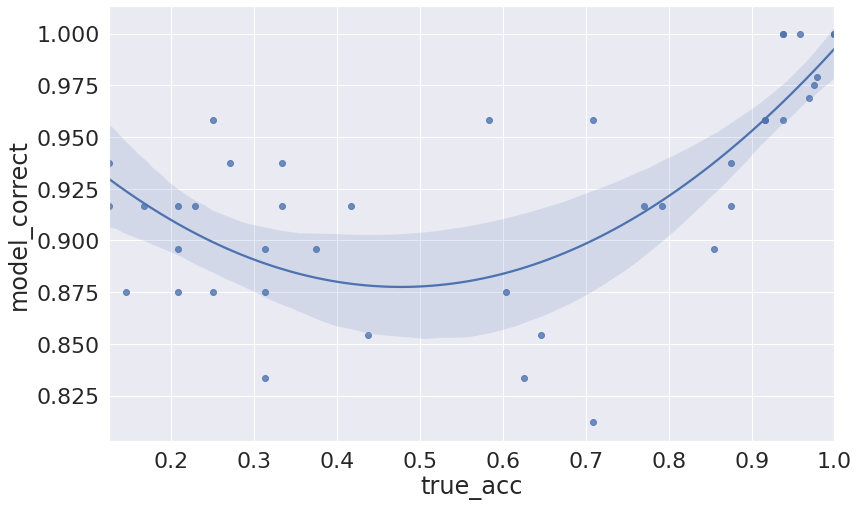

In [184]:
performance_bysubject = best_model_df.groupby('subject', as_index=False)['model_correct'].mean()
subject_mean_acc = best_model_df.groupby('subject', as_index=False)['true_acc'].mean()
model_perf_by_subject = pandas.merge(subject_mean_acc, performance_bysubject, on = 'subject')


seaborn.set(rc={'figure.figsize':(13,8)}, font_scale = 2)
seaborn.regplot(x = 'true_acc', y = 'model_correct', data = model_perf_by_subject, order = 2)
r, p = scipy.stats.pearsonr(model_perf_by_subject.true_acc, model_perf_by_subject.model_correct)
print("R: %.3f\tp-value: %f" % (r, p))

mymodel = np.poly1d(np.polyfit(model_perf_by_subject.true_acc, model_perf_by_subject.model_correct, 2))

print(r2_score(model_perf_by_subject.model_correct, mymodel(model_perf_by_subject.true_acc)))


results = smf.ols(formula='model_correct ~ mymodel(true_acc)', data=model_perf_by_subject).fit()

In [185]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          model_correct   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     51.10
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           1.17e-08
Time:                        20:12:04   Log-Likelihood:                 83.633
No. Observations:                  42   AIC:                            -163.3
Df Residuals:                      40   BIC:                            -159.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.663e-15      0.129    3.6e-14      1.000      -0.262       0.262
mymodel(true_acc)     1.0000      0.140      7.149      0.000       0.717       1.283
==============================================================================
Omnibus:                        0.665   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.128
Skew:                          -0.060   Prob(JB):                        0.938
Kurtosis:                       3.242   Cond. No.                         49.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""